# Wavelet development

This is the development notebook of the wavelet analysis functions. There are two major innovations that I want to test out:

1) Rectifiying the spectra to conserve energy. The rectification follows L07 and V12 and inhibits the explosion of the spectra at larger scales, enabling the diagnosis of smaller scale features.

2) Significance testing using informed decisions about noise. There are two general approaches to hypothesis testing/significance detection. First, is the use of Monte-Carlo simulations, which is largely what is presented in TC98, especially for wavelet coherence. The second is the development of analytic functions for certain classes of null hypotheses (specifically for red noise with CWT and for white noise with coherence). These analytic functions are an innovation from G07 and G08.

Additionally, each general approach will be compared to examples in literature to verify that the pycwt library and my additions to it all function in a consistent way.

Each reference is referred to by the initial of the first author and year (e.g., Ge (2008) will be G08).

### References
Allen, M. R., and L. A. Smith (1996), Monte Carlo SSA: Detecting Irregular Oscillations in the Presence of Colored Noise, J. Clim., 9, 3373–3403, doi:10.1175/1520-0442(1996)009<3373:MCSDIO>2.0.CO;2.

Chavez, M., and B. Cazelles (2019), Detecting dynamic spatial correlation patterns with generalized wavelet coherence and non-stationary surrogate data, Sci. Rep., 9(April), 1–9, doi:10.1038/s41598-019-43571-2.

Ge, Z. (2007), Significance tests for the wavelet power and the wavelet power spectrum, Ann. Geophys., 25(11), 2259–2269, doi:10.5194/angeo-25-2259-2007.

Ge, Z. (2008), Significance tests for the wavelet cross spectrum and wavelet linear coherence, Ann. Geophys., 26(2007), 3819–3829, doi:10.5194/angeo-26-3819-2008.

Gilman, D. L., F. J. Fuglister, and J. J. M. Mitchell (1962), On the Power Spectrum of “Red Noise,” J. Atmos. Sci., 20, 182–184, doi:1520-0469(1963)020<0182:OTPSON>2.0.CO;2.

Liu, Y., S. X. Liang, and R. H. Weisberg (2007), Rectification of the Bias in the Wavelet Power Spectrum, J. Atmos. Ocean. Technol., 24, 2093–2102, doi:10.1175/2007JTECHO511.1.

Torrence, C., and G. P. Compo (1998), A Practical Guide to Wavelet Analysis, Bull. Am. Meteorol. Soc., 79(1), 61–78, doi:https://doi.org/10.1175/1520-0477(1998)079<0061:APGTWA>2.0.CO;2.

Veleda, D., R. Montagne, and M. Araujo (2012), Cross-Wavelet Bias Corrected by Normalizing Scales, J. Atmos. Ocean. Technol., 29, 1401–1408, doi:10.1175/JTECH-D-11-00140.1.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import scipy

# OS interaction
import os
import yaml

# import plotting|
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import string
import datetime
import pandas as pd
import copy
import pyfocs
import pywt
import pycwt as wavelet
from pycwt.helpers import find
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import DateFormatter
from matplotlib import ticker
from matplotlib import colors
import kgraph
from IPython import display 

# Local pycwt helper functions
import pycwt_stat_helpers as cwt_stat
import pycwt_plot_helpers as cwt_plt

/Users/karllapo/anaconda3/lib/python3.7/typing.py:850: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


# Format plots

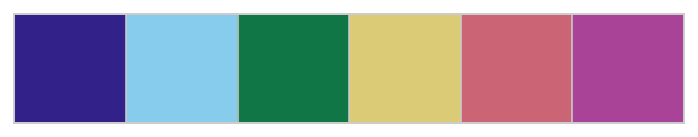

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper")

# Define a default color palette (this should be fairly color blind friendly)
# flatui = ["#3498db",  "xkcd:blue", "xkcd:mustard yellow", 'xkcd:dark yellow', "#95a5a6", "#34495e",]
flatui = kgraph.SRON(6)
sns.set_palette(sns.color_palette(flatui))
sns.palplot(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']
ms_list = ['v', '*', 's', 'o']

alphabet = list(string.ascii_lowercase)

# Test data (from Liu et al., 2007)

In this test I demonstrate the utility of rectification and recreate the plots from L07 for consistency checking.

The synthetic signal has 5 superimposed oscillators with identical amplitudes. Note that I have substantially shortened the synthetic dataset relative to L07 to reduce the computational cost.

### First, without rectification

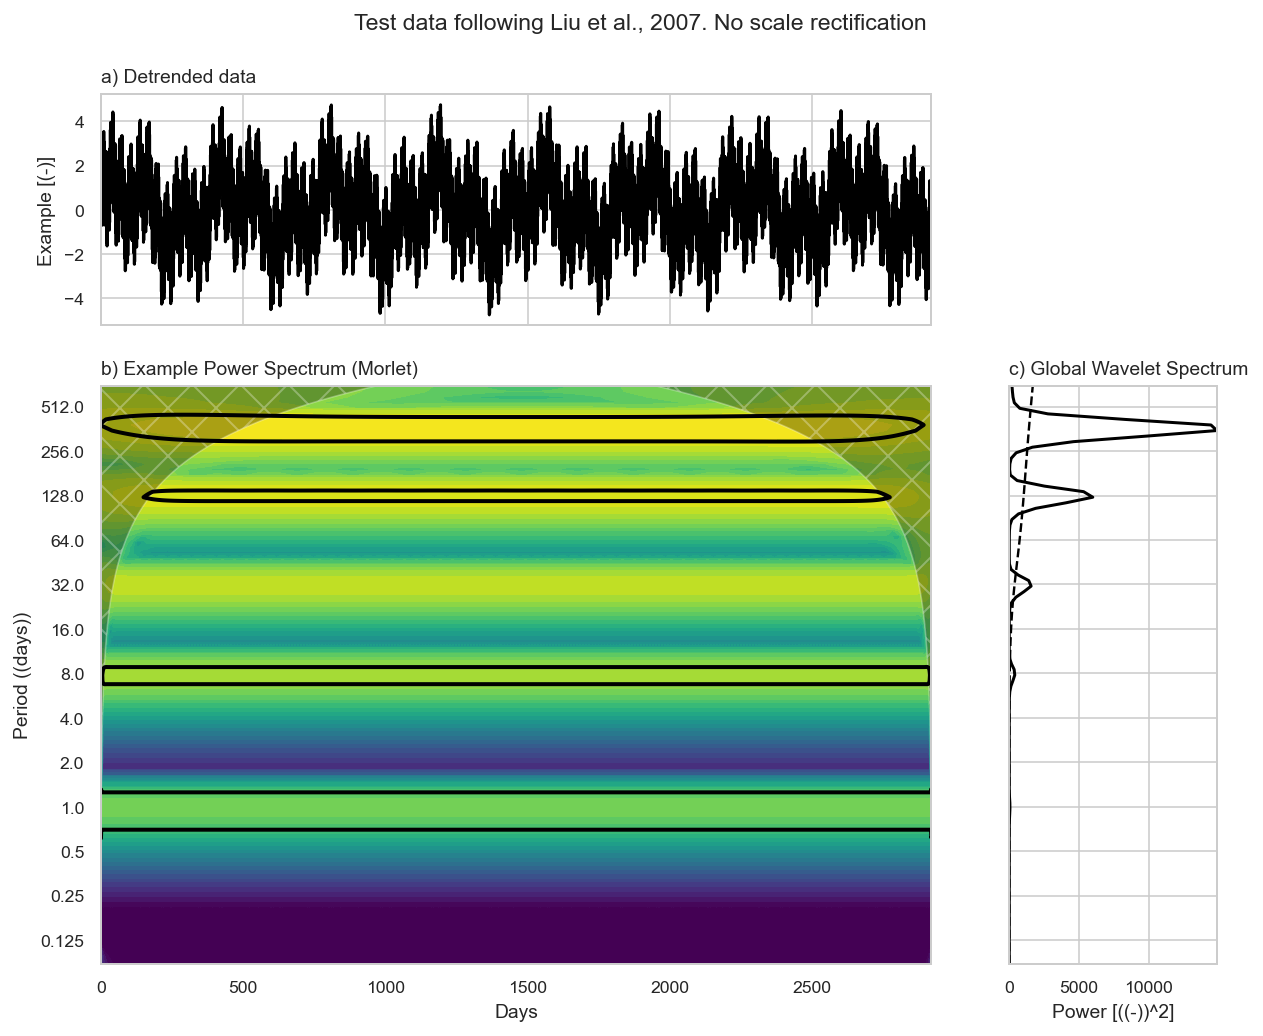

In [3]:
periods_days = np.array([1, 8, 32, 128, 365]) / 24
hours = np.arange(0, 8 * 365, 1 / 24)
signal = np.zeros_like(hours)
for p in periods_days:
    signal = signal + np.sin(hours * 2 * np.pi / (24 * p))

N = signal.size
mother = wavelet.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 8, 13 / (1 / 8)]  

# Perform the CWT
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, 1/24, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False}
)

# Create the periodogram
title = 'Test data following Liu et al., 2007. No scale rectification'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': 'Days'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=1/24,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

Here the problem is quite clear. Even though all of the oscillators have an identical amplitude, the largest scales have the largest spectra peaks.

### Now with rectification

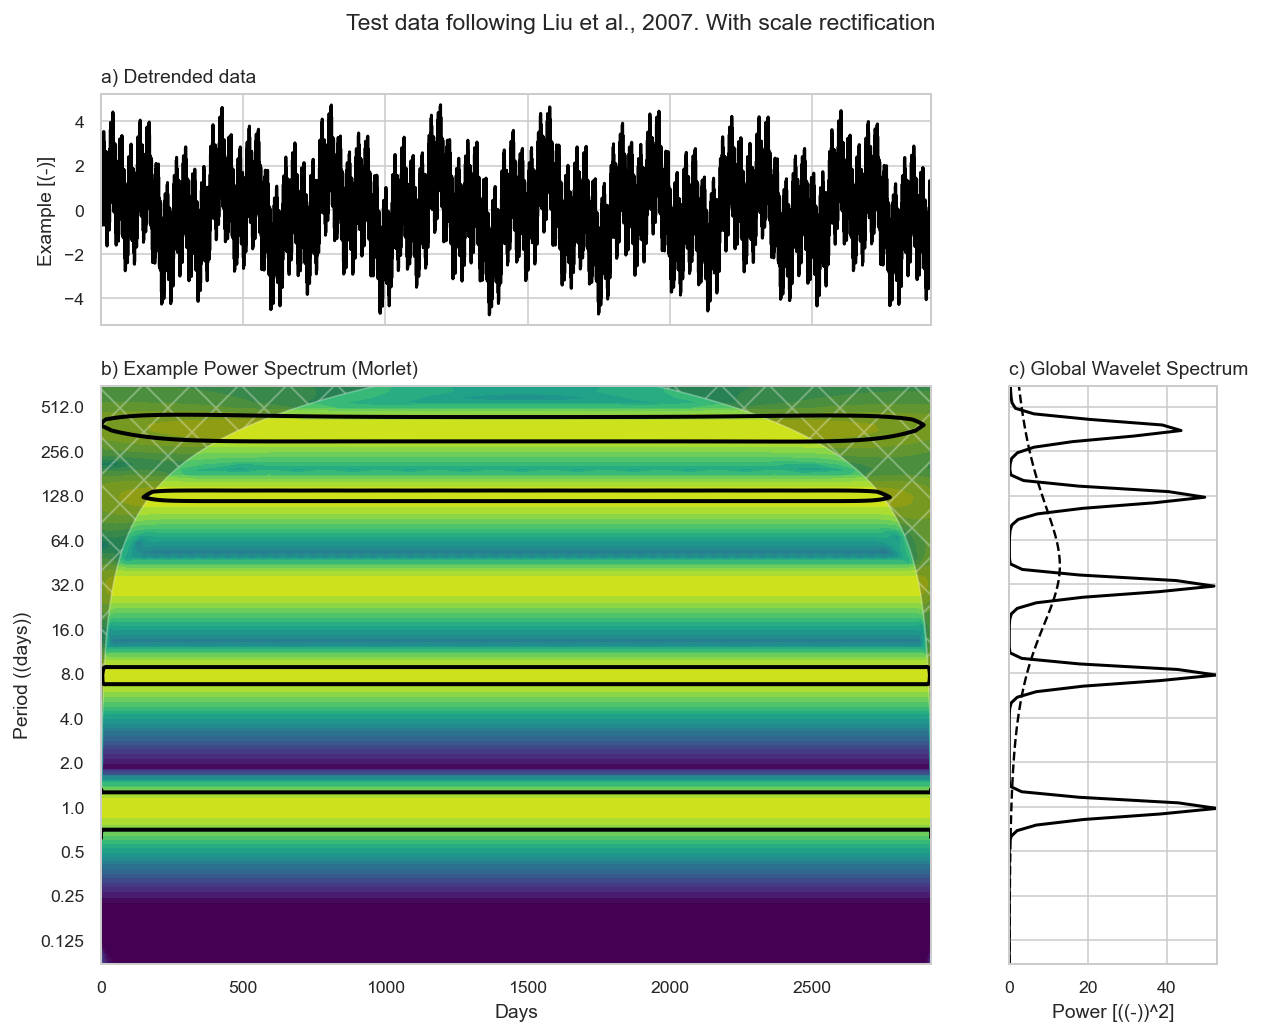

In [4]:
periods_days = np.array([1, 8, 32, 128, 365]) / 24
hours = np.arange(0, 8 * 365, 1 / 24)
signal = np.zeros_like(hours)
for p in periods_days:
    signal = signal + np.sin(hours * 2 * np.pi / (24 * p))

N = signal.size
mother = wavelet.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 8, 13 / (1 / 8)]  

# Perform the CWT (note that rectify=True is the default)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, 1/24, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=True,
    norm_kwargs={'standardize': False, 'detrend': False}
)

# Create the periodogram
title = 'Test data following Liu et al., 2007. With scale rectification'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': 'Days'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=1/24,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

For reference, here is the equivalent plot from L07.

<img src='./figures/Liu2007_Fig2.png' width="600" height="600">

and here is a related plot that looks at just the global (time averaged) wavelet spectra:

<img src='./figures/Liu2007_Fig3.png' width="600" height="600">

I cannot convincingly resolve the difference in the global power between my tests and L07. However, I am skeptical that it is even possible as Figures 2 and 3 give inconsistent results (above).

Figure 2 gives peaks in the time-averaged rectified wavelet spectra of a bit greater than 5. I can approximately recreate that by turning off standardization and scaling the global power by the variance.

Figure 3 gives peaks for _the same quantity_ around ~40. I can approxiamtely recreate peaks of this size by turning on standardization and scaling the global power by the variance.

My suspicion is that everyone is using similar code to generating these kinds of periodograms. The code automatically adjusts the globally-averaged wavelet spectra to be in log2 space (compare Fig 2 and 3e). I suspect a similar process is at play in the below plots. I cannot exactly resolve these differences, however. While it is frustrating that I cannot resolve the small differences, I must move on.

### __pycwt, the rectification, and my helper functions behave as expected__ for the CWT.

# Wavelet Linear Coherence and rectified cross-wavelet transforms

Next we look at the Wavelet Linear Coherence (COH) and the Cross-Wavelet Transform (XWT). For this test we employ the V12 toy data.

There are two signals that have operate at resonant frequencies to each other. Both signals share an oscillatory frequency with a larger amplitude than the others. One of the signals has an additional frequency with an enhanced frequency.

### First, the individual signals

The CWT is scale rectified. Standardizing is on in the `norm_kwargs`. This is the default decision as it means that the CWT operates on data that has a variance of 1, meaning no further scaling is necessary. However, this decision is "controversial" in the sense that standardizing appears to be selectively applied to the global spectra, as above, and will be shown again below.

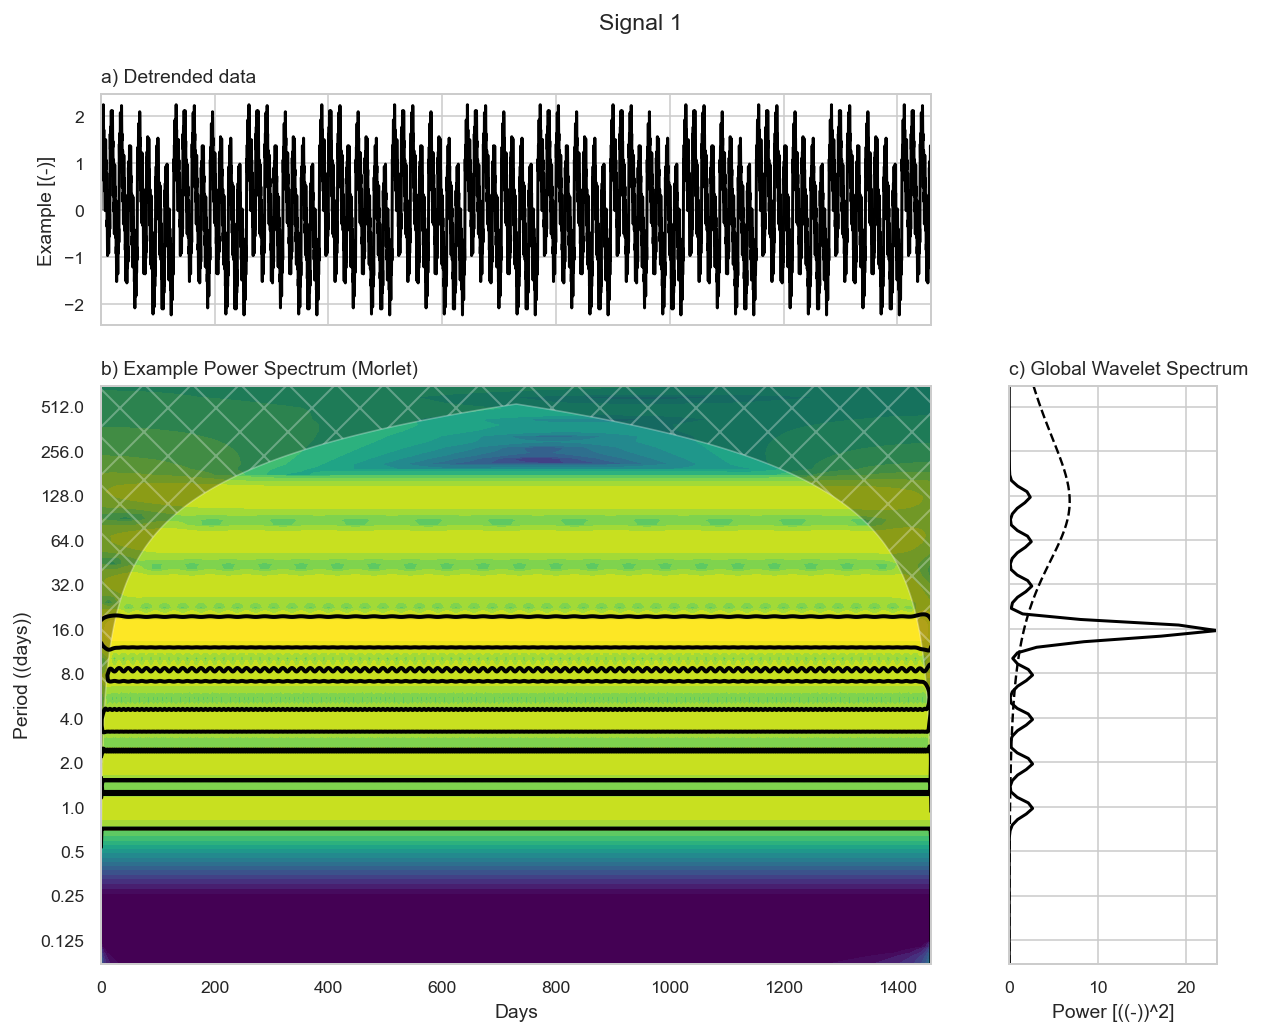

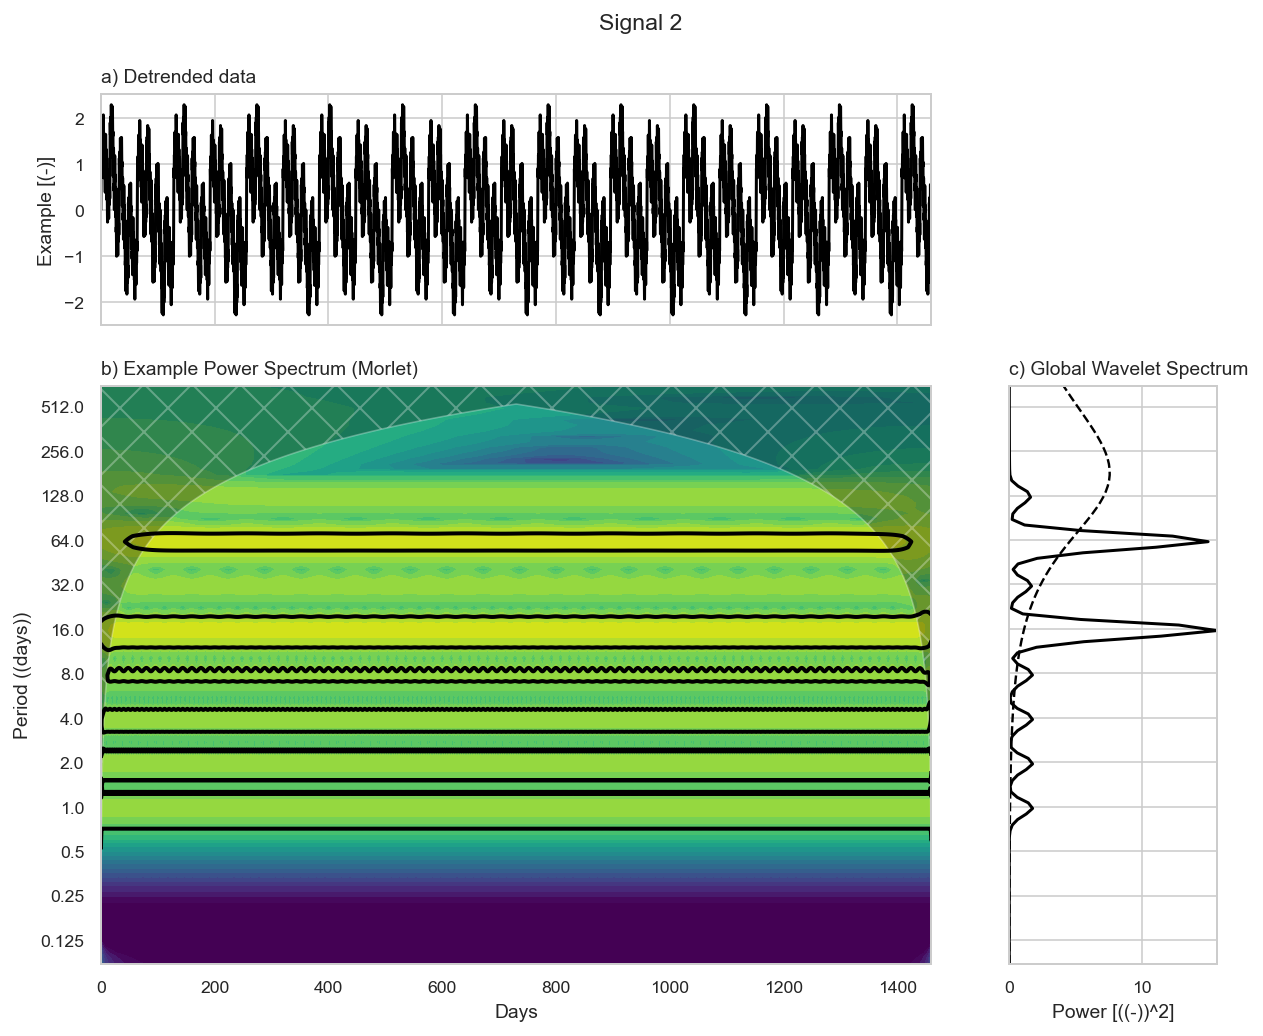

In [5]:
# Build the synthetic data
dx = 1 / 24

periods_days = np.array([1, 2, 4, 8, 16, 32, 64, 128]) / 24
hours = np.arange(0, 365 * 4, 1 / 24)

amplitudes1 = np.array([1, 1, 1, 1, 3, 1, 1, 1, 1])
signal1 = np.zeros_like(hours)
for pnum, p in enumerate(periods_days):
    signal1 = signal1 + np.sin(hours * 2 * np.pi / (24 * p)) * amplitudes1[pnum]

signal2 = np.zeros_like(hours)
amplitudes2 = np.array([1, 1, 1, 1, 3, 1, 3, 1])
for pnum, p in enumerate(periods_days):
    signal2 = signal2 + np.sin(hours * 2 * np.pi / (24 * p)) * amplitudes2[pnum]

# Wavelet arguments
N = signal1.size
mother = wavelet.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 8, 13 / (1 / 8)]  

# Periodogram arguments
title = 'Test data following Veleda et al., 2012'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None, 
    'xlabel': 'Days'
}

# CWT signal 1
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal1, dx, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=False,
    norm_kwargs={'standardize': True, 'detrend': False}
)

fig_labels['title'] = 'Signal 1'
cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=dx,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_labels=fig_labels,
    include_colorbar=False)

# CWT signal 2
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal2, dx, hours, mother, 
    octaves=octaves, scales_to_avg=None,
    glbl_power_var_scaling=False,
    norm_kwargs={'standardize': True, 'detrend': False}
)

fig_labels['title'] = 'Signal 2'
cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=dx,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    fig_labels=fig_labels,
    include_colorbar=False
)

For reference, here are the equivalent figures from V12

__signal 1__

<img src='./figures/veleda2012_Fig1.png' width="600" height="600">


__signal 2__

<img src='./figures/veleda2012_Fig2.png' width="600" height="600">


### Scaling the global power

There are some annoying inconsistencies here, which makes testing the toy dataset difficult. If I turn off standardizing I get a time series with amplitude between [-5, 5] (consistent with Figure 2). But that yields a larger global wavelet spectrum (~40 for the peaks) as opposed to the values of 15 we see above and the values of ~4 that they plot in their figures. There are some other factors that make me skeptical, such as inconsistent axis units.

However! After a bunch of detective work, I think that these globally-averaged power spectra are in `log2` and not linear. I demonstrate that below.

### Inconsistent significance/non-stationarity tests

In my version of the plots above, I've included signficance testing. Here, the data are tested against an AR(1) process determined by operating on the input signals. Since these data does not have any lag built in, the AR(1) null hypothesis should be negligible and indicate that signal frequencies are significant. Instead, those are treated as "not significant". These definitions and usage will be explored below.

Text(0.5, 0, 'Period (days)')

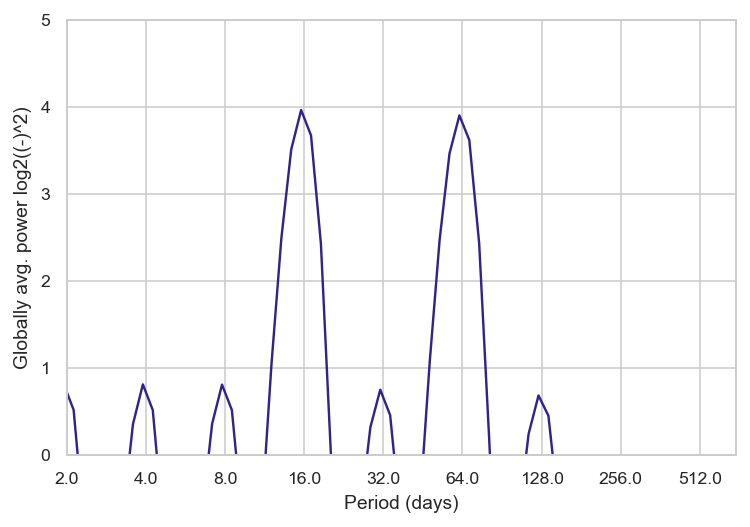

In [6]:
# Plot the globally averaged power in log2 space

plt.plot(np.log2(period), np.log2(glbl_power))
ax = plt.gca()
ax.set_ylim(0, 5)

Yticks = 2 ** np.arange(
    np.ceil(np.log2(period.min())),
    np.ceil(np.log2(period.max())))

ax.set_xticks(np.log2(Yticks))
ax.set_xticklabels(Yticks)
plt.setp(ax.get_xticklabels(), visible=True)
ax.set_xlim(np.log2([2, period.max()]))
ax.set_ylabel('Globally avg. power log2((-)^2)')
ax.set_xlabel('Period (days)')

That is the closest I have come to reproducing the results from this paper. These peaks are slightly larger than those in the paper, but I think that's explainable through small variations in the wavelet implementation (e.g., they don't state the wavelet parameters and I don't know what code they are implmenting). The best part of this is that the relative peak sizes is similar to the published method.

# Cross-wavelet Transform (XWT)

Here the rectification from V12 will be employed.

No handles with labels found to put in legend.


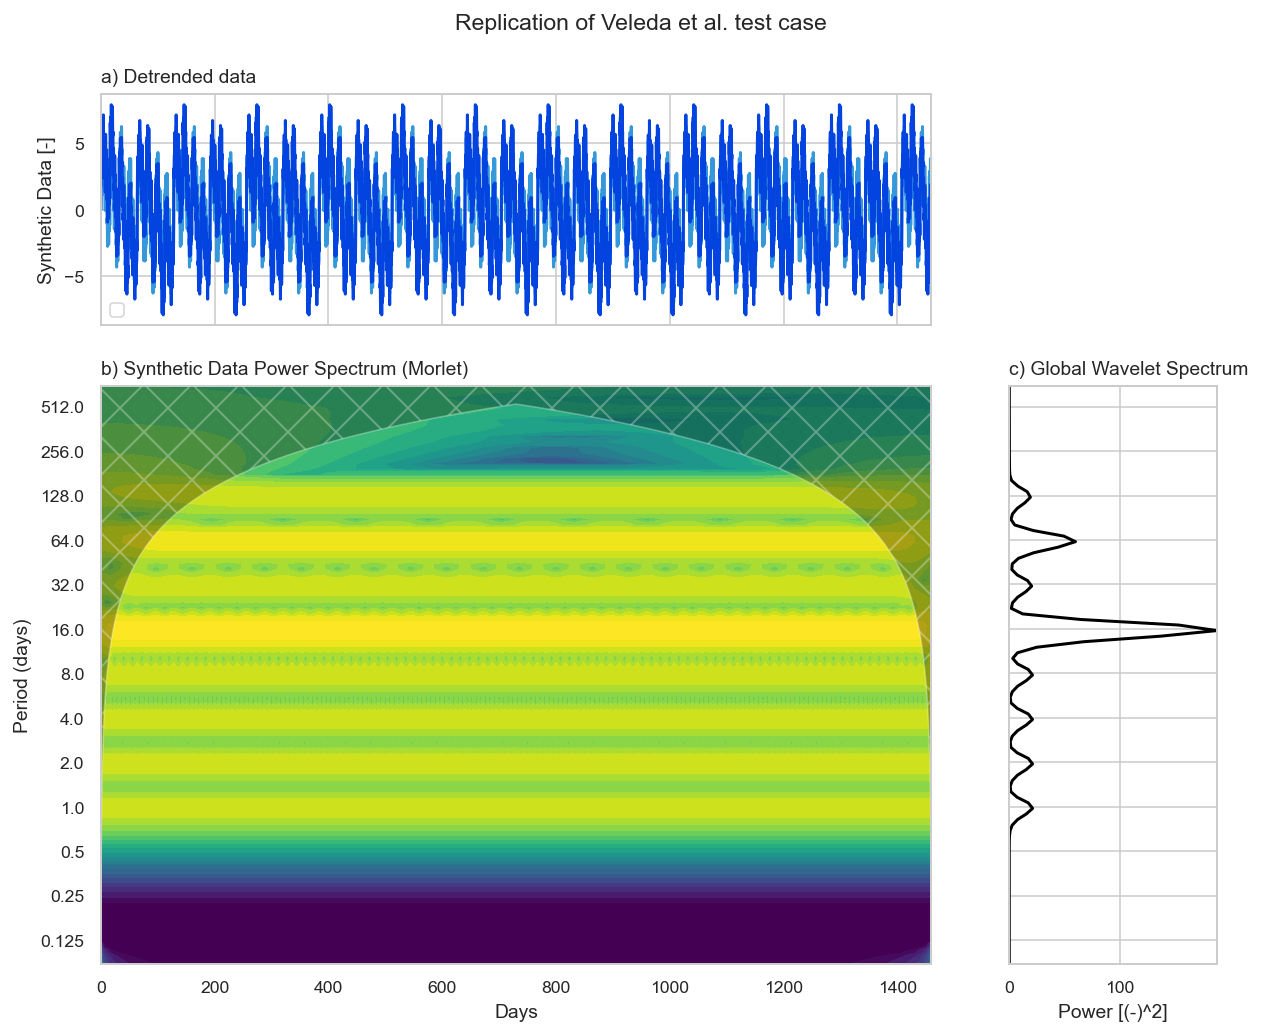

In [7]:
(WCT, aWCT, W12,
 periods, coi, angle,
 s1, s2) = cwt_stat.wavelet_coherent(
    signal1,
    signal2,
    dx,
    octaves[0],
    2 * dx,
    octaves[1],
    mother,
    norm_kwargs={'standardize': True, 'detrend': False}
)

# Cross wavelet spectra
fig_labels = {
    'title': 'Replication of Veleda et al. test case',
    'label': 'Synthetic Data',
    'units': '-',
    'scale_units': 'days',
    'mother': mother.name,
    'avg_scales': 'None',
    'xlabel': 'Days'
}

cwt_plt.plot_wv_power(
    signal_norm=[signal1, signal2],
    x=hours,
    dx=dx,
    period=periods,
    power=np.abs(W12),
    coi=coi,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)



(1.0, 9.461938710946555)

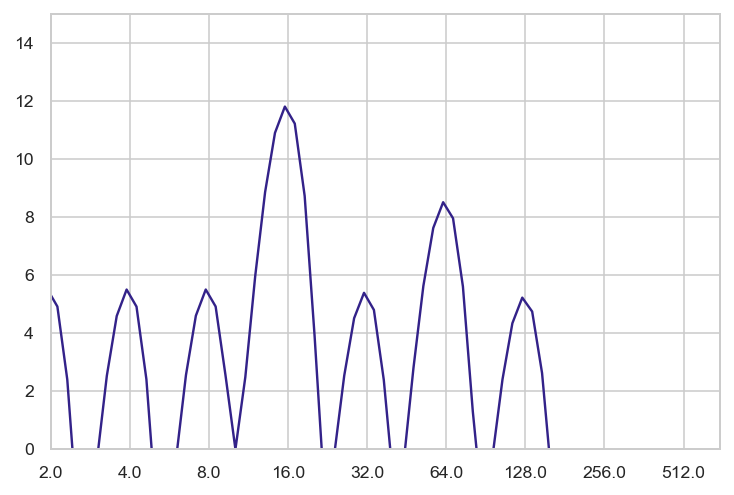

In [8]:
# plt.plot(periods, np.abs(W12.mean(axis=1)) ** 2)
plt.plot(np.log2(periods), np.log2(np.abs(W12.mean(axis=1)) ** 2 / (signal1.std() * signal2.std())))
# plt.plot(np.log2(periods), np.log2(W12.mean(axis=1)))
ax = plt.gca()
ax.set_ylim(0, 15)
# ax.set_xlim(2, 256)

Yticks = 2 ** np.arange(
    np.ceil(np.log2(period.min())),
    np.ceil(np.log2(period.max())))

ax.set_xticks(np.log2(Yticks))
ax.set_xticklabels(Yticks)
plt.setp(ax.get_xticklabels(), visible=True)
ax.set_xlim(np.log2([2, period.max()]))


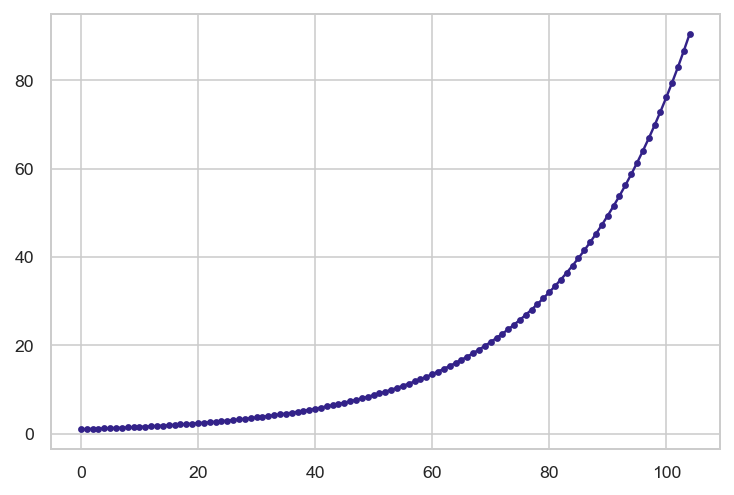

In [38]:
s0 = 2 * dx
J = octaves[1]
dj = octaves[0]

# sj = 2 ** (np.arange(0, J + 1) * dj)
# plt.plot(sj, marker='.')

sj = 2 ** (np.arange(0, J + 1) * dj / 2)
plt.plot(sj, marker='.')

In [23]:
def wavelet_coherent(
    s1,
    s2,
    dx,
    dj,
    s0,
    J,
    mother,
    norm_kwargs={'detrend': True, 'standardize': True},
    ):
    '''
    Calculate coherence between two vectors for a given wavelet. Currently
    only the Morlet wavelet is implemented. Returns the wavelet linear coherence
    (also known as coherency and wavelet coherency transform), the cross-wavelet
    transform, and the phase angle between signals.

    INPUTS:
        s1 - 1D numpy array or similar object of length n. Signal one to
            perform the wavelet linear coherence with against with s2. Assumed
            to be pre-formatted by the `standardaize` function. s1 and s2 must
            be the same size.
        s2 - 1D numpy array or similar object of length n. Signal two to
            perform the wavelet linear coherence with against with s1. Assumed
            to be pre-formatted by the `standardaize` function. s1 and s2 must
            be the same size.
        dx - scalar or float. Spacing between elements in s1 and s2. s1 and s2
            are assumed to have equal spacing.
        dj - float, number of suboctaves per octave expressed as a fraction.
            Default value is 1 / 12 (12 suboctaves per octave)
        s0 - Smallest scale of the wavelet (if unsure = 2 * dt)
        J - float, number of octaves expressed as a power of 2 (e.g., the
            default value of 7 / dj means 7 powers of 2 octaves.
        mother - pycwt wavelet object, 'Morlet' is the only valid selection as
            a result of requiring an analytic expression for smoothing the
            wavelet.

    RETURNS:
        WCT - same type as s1 and s2 of length n, the wavelet coherence
            transform.
        aWCT - same type as s1 and s2 of length n, phase angle between s1 and
            s2.
        W12 - same type as s1 and s2 of length n, the cross-wavelet transform.
            Power is rectified following Veleda et al., 2012.
        period - numpy array of length p, fourier mode inverse frequency.
        coi - numpy array  of length n, cone of influence
        angle - phase angle in degrees
        w1 - same type as s1 (n by p),  CWT for s1
        w2 - same type as s1 (n by p),  CWT for s2
    '''
    assert mother.name == 'Morlet', "XWT requires smoothing, which is only available to the Morlet mother."
    wavelet_obj = wavelet.wavelet._check_parameter_wavelet(mother)

    assert np.size(s1) == np.size(s2), 's1 and s2 must be the same size.'

    # s1 and s2 MUST be the same size
    assert s1.shape == s2.shape, "Input signals must share the exact same shape."

    s1_norm = cwt_stat.standardize(s1, **norm_kwargs)
    s2_norm = cwt_stat.standardize(s2, **norm_kwargs)

    # Calculates the CWT of the time-series making sure the same parameters
    # are used in both calculations.
    W1, sj, freq, coi, _, _ = wavelet.cwt(s1_norm, dx, dj, s0, J, mother)
    W2, _, _, _, _, _ = wavelet.cwt(s2_norm, dx, dj, s0, J, mother)

    # We need a 2D matrix for the math that follows
    scales = np.atleast_2d(sj)
    periods = np.atleast_2d(1 / freq)

    # Perform the cross-wavelet transform
    W12 = W1 * W2.conj()
    # Here I follow the R biwavelet package for the implementation of the
    # scale rectification. Note that the R package normalizes by the largest
    # wavelet scale. I choose to not include that scaling factor here.
    # W12_corr = W1 * W2.conj() * np.max(periods) / periods.T 
    W12_corr = W1 * W2.conj() / periods.T 

    # Coherence

    # Smooth the wavelet spectra before truncating.
    if mother.name == 'Morlet':
        sW1 = wavelet_obj.smooth((np.abs(W1) ** 2 / scales.T), dx, dj, sj)
        sW2 = wavelet_obj.smooth((np.abs(W2) ** 2 / scales.T), dx, dj, sj)
        sW12 = wavelet_obj.smooth((W12 / scales.T), dx, dj, sj)
    WCT = np.abs(sW12) ** 2 / (sW1 * sW2)
    aWCT = np.angle(W12)
    # @ fix this incorrect angle conversion.
    angle = (0.5 * np.pi - aWCT) * 180 / np.pi

    # @ better names to reflect fourier vs wavelet frequency/scale
    scales = np.squeeze(scales)

    return (WCT, aWCT, W12, W12_corr, 1 / freq, coi, angle, s1, s2)

In [30]:
(WCT, aWCT, W12,
 W12_corr, period,
 coi, angle, s1, s2) = wavelet_coherent(
    signal1,
    signal2,
    dx,
    octaves[0],
    2 * dx,
    octaves[1],
    mother,
    norm_kwargs={'standardize': True, 'detrend': False}
)


No handles with labels found to put in legend.


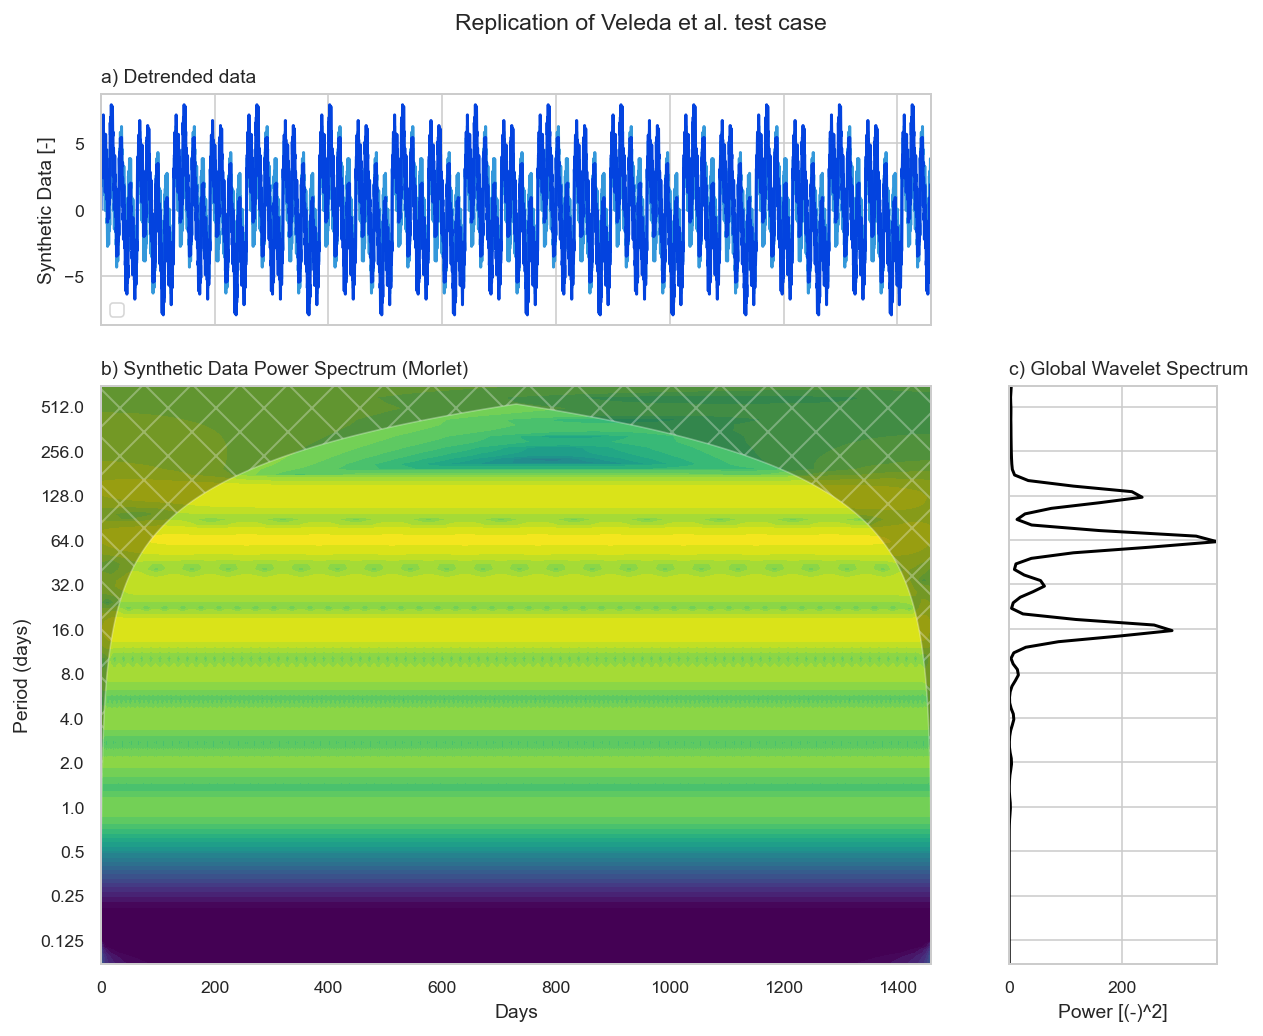

In [31]:
# Power is NOT squared since it is already the product of
# two wavelet spectra. Instead, we just take the absolute value
# of the complex values.

cwt_plt.plot_wv_power(
    signal_norm=[signal1, signal2],
    x=hours,
    dx=dx,
    period=period,
    power=np.abs(W12),
    coi=coi,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

No handles with labels found to put in legend.


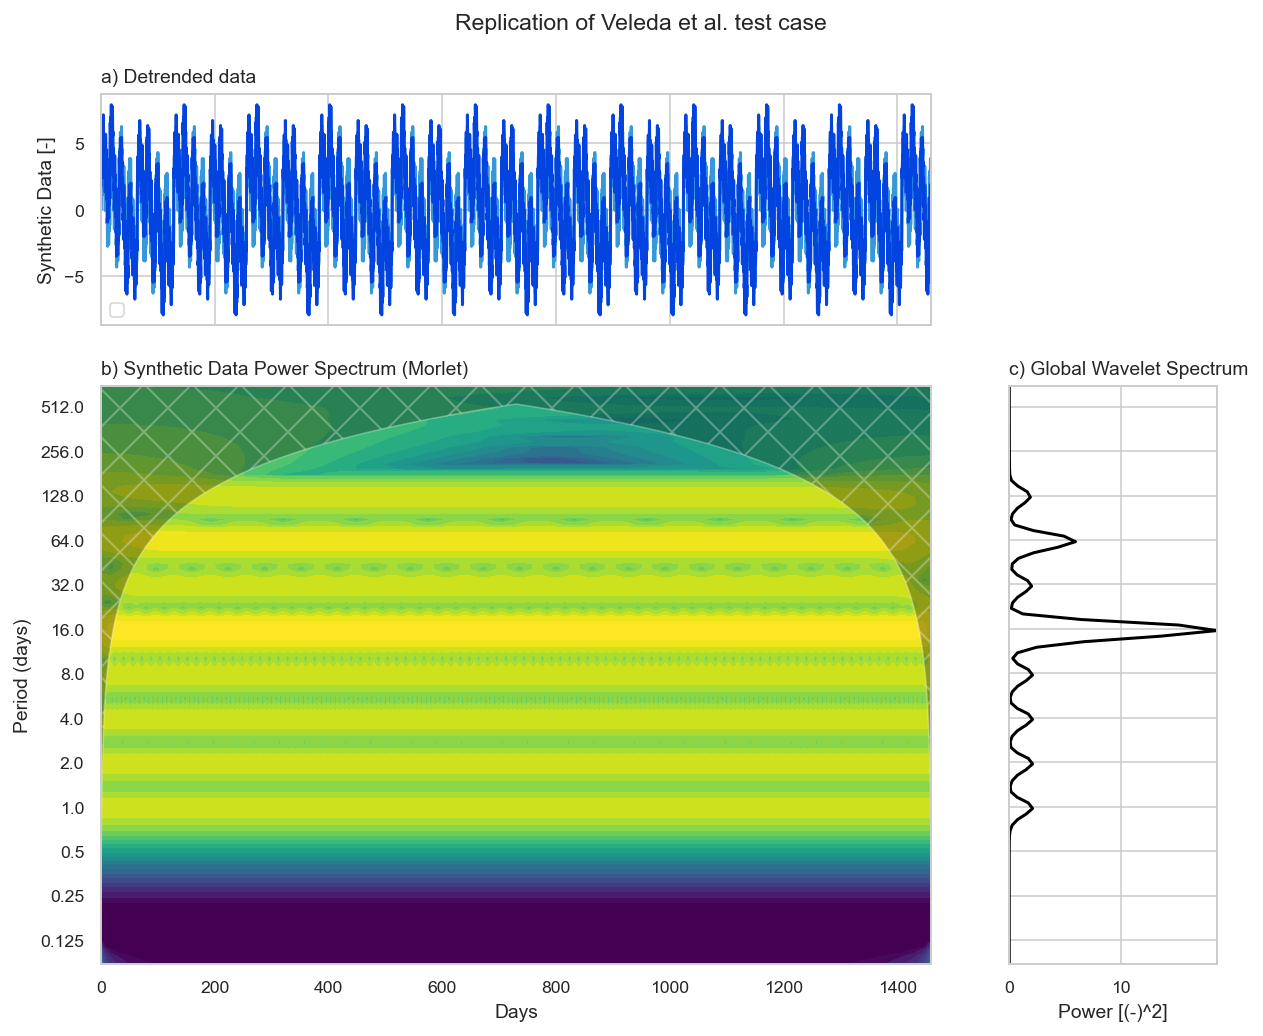

In [32]:
# Power is NOT squared since it is already the product of
# two wavelet spectra. Instead, we just take the absolute value
# of the complex values.

cwt_plt.plot_wv_power(
    signal_norm=[signal1, signal2],
    x=hours,
    dx=dx,
    period=period,
    power=np.abs(W12_corr),
    coi=coi,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

As a side note I have confirmed that my version of the code and the pycwt code produce identical results when no rectification is provided (not shown).

No handles with labels found to put in legend.


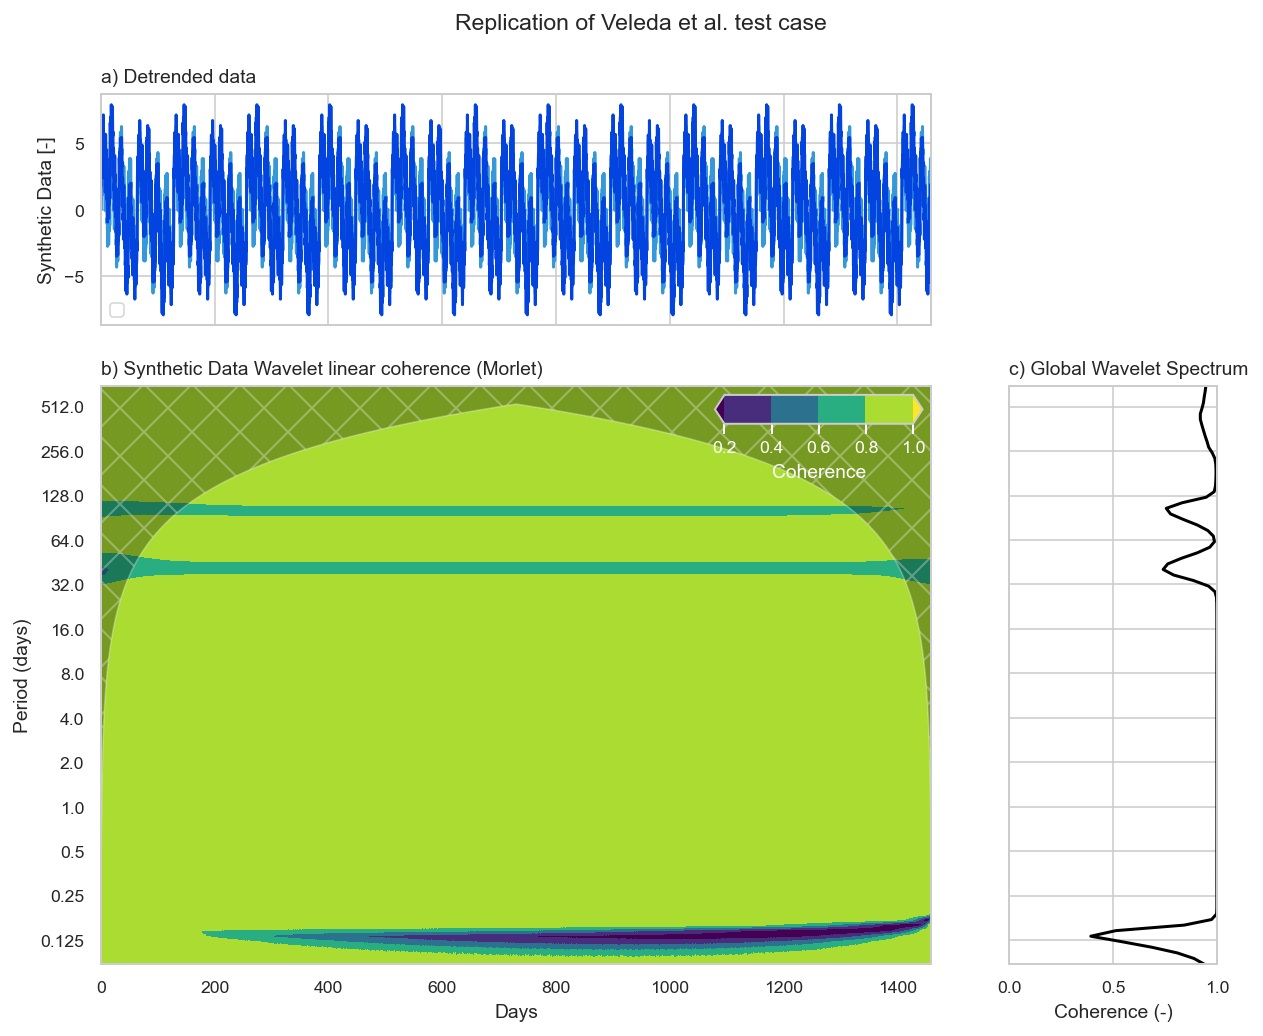

In [40]:
# Power is NOT squared since it is already the product of
# two wavelet spectra. Instead, we just take the absolute value
# of the complex values.

cwt_plt.plot_wv_power(
    signal_norm=[signal1, signal2],
    x=hours,
    dx=dx,
    period=period,
    power=WCT,
    coi=coi,
    fig_kwargs=None,
    fig_labels=fig_labels,
    levels=np.arange(0.2, 1.1, 0.2),
    include_colorbar=True,
    coherence=True,
    log_power=False,
)

Since the two signals are identical except for the amplitude the coherence is practically 1. I am a bit weirded out that the two signals with different amplitudes ended up with less coherence, even though they should co-vary identically.

### First, make sure coherence returns a value of 1 when given two identical signals

In [43]:
(WCT, aWCT, W12,
 W12_corr, period,
 coi, angle, s1, s2) = cwt_stat.wavelet_coherent(signal1, signal1, dx, octaves[0], 2 * dx, octaves[1], mother)

fig_labels = {
    'title': 'Identify test',
    'label': 'Synthetic Data',
    'units': '-',
    'scale_units': 'days',
    'mother': mother.name,
    'avg_scales': 'None',
    'xlabel': 'Dayds'
}

cwt_plt.plot_wv_power(
    signal_norm=signal1,
    x=hours,
    dx=dx,
    period=periods,
    power=WCT,
    coi=coi,
    levels=np.arange(0, 1.2, 0.2),
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

ValueError: not enough values to unpack (expected 9, got 8)

### Now test with some noise instead

In [ ]:
signal1 = signal1 + 0.25 * np.random.normal(0, 1, size=len(signal2))
signal2 = signal2 + 0.1 * np.random.normal(0, 1, size=len(signal2))

(WCT, aWCT, W12, periods, coi, angle, s1, s2) = wavelet_coherent(signal1, signal2, dx, octaves[0], 2 * dx, octaves[1], mother)

fig_labels = {
    'title': 'Replication of Veleda et al. test case',
    'label': 'Synthetic Data',
    'units': '-',
    'scale_units': 'days',
    'mother': mother.name,
    'avg_scales': 'None',
    'xlabel': 'Dayds'
}

plot_wv_power(signal_norm=signal1,
              x=hours,
              dx=dx,
              period=periods,
              power=WCT,
              coi=coi,
              levels=np.arange(0, 1.1, 0.2),
              log_power=False,
              fig_kwargs=None,
              fig_labels=fig_labels,
              include_colorbar=False,
              coherence=True
             )

Here we can see the effects of scale smoothing. The white noise is smoothed into the shorter time scales.

Next, do this following the matlab example, which has time varying frequencies. This gives a better test for verifying the behavior of the pycwt functions.

In [ ]:
if test_data:
    t = np.arange(0, 2, 0.001)
    x = np.cos(2 * np.pi * 10 * t) * ((t >= 0.5) & (t < 1.1)) + np.cos(2 * np.pi * 50 * t) * ((t >= 0.2) & (t < 1.4)) + 0.25 * np.random.normal(0, 1, size=len(t))
    y = np.sin(2 * np.pi * 10 * t) * ((t >= 0.6) & (t < 1.2)) + np.sin(2 * np.pi * 50 * t) * ((t >= 0.4) & (t < 1.6)) + 0.35 * np.random.normal(0, 1, size=len(t))
    fig, ax = plt.subplots(1, 1)
    ax.plot(t, x, label='Signal 1')
    ax.plot(t, y, label='Signal 2')
    ax.set_ylabel('Signal amplitude (-)')
    ax.set_xlabel('Time (-)')
    ax.set_title('Toy dataset following MATLABs documentation')
    ax.legend()

    (WCT, aWCT, W12, periods, coi, angle, s1, s2) = wavelet_coherent(x, y, 0.001, octaves[0], 2 * 0.001, octaves[1], mother)

    fig, ax = plt.subplots(1, 1,)
    plot_periodogram(WCT, t, 0.001, periods, coi=coi, ax=ax, sig95=None, levels=np.arange(0, 1, 0.1), log_power=False)
    ax.set_title('COH of MATLAB toy dataset')
    ax.set_ylabel('Period (s)')
    ax.set_xlabel('Time (s)')

That behaves as expected. One last remaining question is whether I need to normalize both time series if they have different e.g. amplitudes. One of the assumptions I can use when working with DTS is the knowledge that the underlying physical noise from the instrument is consistent from one bin to the next, even if the observations have different variances. Any differences in the data's standard deviation with height are a function of changes in the underlying physical process, not changes in the DTS. In other words, within the SBL the relatively larger temperature perturbations are a real thing and their influence is something we wish to examine.

Here I run two tests:
1) One function has a smaller amplitude than the other (should I normalize?)

2) One function has a long-term non-stationarity that the other does not (e.g. comparing the SBL to residual layer, should I detrend?)

In [ ]:
# Generate test data for case number 1.
t = np.arange(0, 2, 0.001)
x = (
    5 * (
        np.cos(2 * np.pi * 10 * t) * ((t >= 0.5) & (t < 1.1))
        + np.cos(2 * np.pi * 50 * t) * ((t >= 0.2) & (t < 1.4))
        + 0.25 * np.random.normal(0, 1, size=len(t))
    )
)
y = (
    np.sin(2 * np.pi * 10 * t) * ((t >= 0.6) & (t < 1.2))
    + np.sin(2 * np.pi * 50 * t) * ((t >= 0.4) & (t < 1.6))
    + 0.35 * np.random.normal(0, 1, size=len(t))
)

# And plot the COH results
fig, ax = plt.subplots(1, 1)
ax.plot(t, x, label='Signal 1')
ax.plot(t, y, label='Signal 2')
ax.set_ylabel('Signal amplitude (-)')
ax.set_xlabel('Time (-)')
ax.set_title('Toy dataset with different amplitudes')
ax.legend()

(WCT, aWCT, W12, periods, coi, angle, s1, s2) = wavelet_coherent(x, y, 0.001, octaves[0], 2 * 0.001, octaves[1], mother)

fig, ax = plt.subplots(1, 1,)
plot_periodogram(WCT, t, 0.001, periods, coi=coi, ax=ax, sig95=None, levels=np.arange(0, 1, 0.1), log_power=False)
ax.set_title('COH of toy dataset with different amplitudes')
ax.set_ylabel('Period (s)')
ax.set_xlabel('Time (s)')

Standardizing does not create a qualitatively different time series. That's good! And I think even expected, given that the definition of wavelet coherency actually normalizes by the standard deviation using some of the substitutions (I belive eq 14 from TC98 compared to eq 24).

In [ ]:
# Generate test data for case number 1.
t = np.arange(0, 2, 0.001)
x = (
    5 * t + (
        np.cos(2 * np.pi * 10 * t) * ((t >= 0.5) & (t < 1.1))
        + np.cos(2 * np.pi * 50 * t) * ((t >= 0.2) & (t < 1.4))
        + 0.25 * np.random.normal(0, 1, size=len(t))
    )
)
y = (
    np.sin(2 * np.pi * 10 * t) * ((t >= 0.6) & (t < 1.2))
    + np.sin(2 * np.pi * 50 * t) * ((t >= 0.4) & (t < 1.6))
    + 0.35 * np.random.normal(0, 1, size=len(t))
)

# And plot the COH results
fig, ax = plt.subplots(1, 1)
ax.plot(t, x, label='Signal 1')
ax.plot(t, y, label='Signal 2')
ax.set_ylabel('Signal amplitude (-)')
ax.set_xlabel('Time (-)')
ax.set_title('Toy dataset with secular trend')
ax.legend()

(WCT, aWCT, W12, periods, coi, angle, s1, s2) = wavelet_coherent(x, y, 0.001, octaves[0], 2 * 0.001, octaves[1], mother)

fig, ax = plt.subplots(1, 1,)
plot_periodogram(WCT, t, 0.001, periods, coi=coi, ax=ax, sig95=None, levels=np.arange(0, 1, 0.1), log_power=False)
ax.set_title('COH of toy dataset with secular trend')
ax.set_ylabel('Period (s)')
ax.set_xlabel('Time (s)')

Here there are some qualitative changes in the lower, more relavant time scales for the analysis. The longer time scales actually become more accurate as the melange of coherence above the largest time scales in the synthetic dataset are diminished. Weird! But, yeah, I guess I will detrend.

# Wavelet significance testing

There are two types of significance tests that I need to prototype and understand in this notebook.

1) Significance tests for coherence. I will follow Ge (2008), referred to as G08, in which an analytic expression for the expected spectra from two white noise gaussian processes are convolved. They develop three tests: wavelet linear coherence, phase angle, and the cross wavelet transform. I am mostly concerned here with the WLC test, but if the other two are relatively trivial to implement I will also include those.

2) Signficance tests for CWT following Torrence and Compo (1998), reffered to as TC98. Here the analytic expressions are for the expected spectra of a red noise process or AR(1).

The general goal is to move away from Monte Carlo simulations, if possible. Or to formalize the process for deriving Monte-Carlo wavelet significance for the DTS data, such that I do not have to consistently recalculate the spectra for each script.


## Signficance testing

This is a painfully slow process. Since it shouldn't materially change, we can just keep track of this one realization and approximately apply it to all other flights. The flights only vary in their estimate of the lag-1 autocorrelation and length, which may alther this shape a little. However it isn't clear that we are actually testing against a red noise null hypothesis, so for now I'll accept that uncertainty.

## The pywct built-in function for referece

This function is unreasonbly slow, due to the Monte-Carlo significance testing. The Monte-Carlo results are included as a text snippet:

The results from the significance test for FlyFOX on July 23rd with

```
sig_testing = False
if sig_testing:
    sig = wavelet.wct_significance(0.8, 0.8, dt=dx, dj=dj, s0=s0, J=np.int(J),
                           significance_level=0.95,
                           wavelet=mother, cache=False)

dj = 1/12 # Twelve sub-octaves per octaves
s0 = 2 * dx # Starting scale, here 6 months
J = 8 / dj # Seven powers of two with dj sub-octaves

sig = np.array([0.81401639, 0.78345545, 0.75279858, 0.7226635 , 0.69350109,
       0.66652241, 0.64147332, 0.62004038, 0.60550525, 0.59619792,
       0.59208776, 0.59072181, 0.58914302, 0.58921696, 0.58864916,
       0.58791544, 0.58771774, 0.58681882, 0.58635698, 0.58501009,
       0.58401166, 0.5835097 , 0.58349667, 0.58467324, 0.585693  ,
       0.58655234, 0.5863466 , 0.58624939, 0.58686015, 0.58659448,
       0.58678618, 0.58726164, 0.58603571, 0.58563789, 0.58549894,
       0.58386848, 0.58320097, 0.58234965, 0.58292099, 0.58314303,
       0.58221027, 0.58186458, 0.58228747, 0.58382872, 0.58571046,
       0.58604665, 0.58597749, 0.58591532, 0.58626835, 0.58721651,
       0.58765012, 0.58995332, 0.58966892, 0.58934133, 0.58651515,
       0.58232936, 0.58114409, 0.58075262, 0.58063482, 0.58336237,
       0.5848144 , 0.58410801, 0.5826817 , 0.58313725, 0.58381667,
       0.58499733, 0.58684185, 0.58420528, 0.58095385, 0.58555905,
       0.58851972, 0.59066504, 0.59348441, 0.59728856, 0.60067726,
       0.60047013, 0.60054622, 0.59985914, 0.60139413, 0.60939136,
       0.61795857, 0.61604744, 0.62274909, 0.62588975, 0.62892926,
       0.63144272, 0.63280975, 0.62892239, 0.62442544, 0.62464069,
       0.62672532, 0.64305479, 0.66582609, 0.6909901 , 0.71090922,
       0.72671429,        nan])
```

# Wavelet Linear Coherence and Cross-Wavelet Spectra Significance Testing

As most of the theoretical work on wavelets employs the Morlet wavelet, the following discussion will presume this wavelet.

From Ge 2008:

$$
D_{\alpha}(L_{xy}) = tanh^2 \left(s_{\alpha} \sqrt{\frac{2 \sqrt{\ln(\kappa)} f_c F_s}{mf}} \right)
$$

where $D_{\alpha}$ is the significance level of a wavelet linear coherence given by $L_{xy}$, $s_\alpha$ is the $1 - \alpha$ significance level in percentile, $\kappa$ is the decorrelation parameter, $f_c$ is undefined but somehow related to the conversion between fourier frequency and wavelet scale, $F_s$ is the sampling frequency (\delta t is the sampling period, the inverse of the sampling frequency), $m$ is the number of data points, and $f$ is the (fourier?) frequency. 

### Detective work on what $f_c$ is:

This expression uses the equivalent fourier frequencies, not the wavelet scales. From TC98, Table 1 we have the following expression for converting between wavelet (time?) scale $s$ and fourier frequency.

$$
\lambda = \frac{4 \pi s}{\omega_0 + \sqrt{2 + \omega_0^2}}
$$

where $\lambda$ is the fourier wavelength and $\omega_0$ is the non-dimensional frequency. The Morlet wavelet is commonly employed with $\omega_0=6$. Note that other wavelets have different non-dimensional scales in their definition that are not frequency.


My suspicion is that equation 12 in G08 in which $f_c$ appears is an approximation of the above expression. To verify, we can convert the above expression into frequencies (instead of wavelengths).

Note that there are multiple notation differences between G08 and TC98. The dilation scale in TC98 is $s$ and in G08 is $a$. Here I hint at what I believe is the result by calling the converted wavelet scale to fourier scale $f_c$.

$$
f_c = \frac{(\omega_0 + \sqrt{2 + \omega_0^2})}{4 \pi a}
$$

Solving for $a$

$$
a = \frac{4 \pi}{f(\omega_0 + \sqrt{2 + \omega_0^2})}
$$

We can quickly compute this value using pycwt as this identify is built-in as a property of the mother wavelet. Note that I get the same result when doing this step manually.

In [3]:
mother = wavelet.Morlet(6.)
a = 1 / (mother.flambda())

print('a = {:0.3f} / f'.format(a))

a = 0.968 / f


And here is where my confusion is (and why I am being so careful on this step). In G08, this expression, which I am only inferring since it was never defined, is eq 12.

$$
a = \frac{f_c}{f} \approx \frac{0.9394}{f} 
$$

Clearly a slightly different result. Given that I understand the TC98 expression, that it appears in pycwt in a cleanly documented way, and that G08 is not so clear in their definition I will continue using this value, which has the added benefit of being easily derived for any wavelet employed in pycwt. $f_c$ is the fourier mode conversion for each wavelet, defined in Table 1 of TC98 and in the `flambda` property of a pycwt wavelet object.

In [4]:
def wlc_gwn_sig(mother, m, f, F_s, s_a=None, kappa=None):

    if s_a is None:
        s_a = 0.05
    if kappa is None:
        kappa = 5
    f_c = 1 / mother.flambda()
    F_s = 10

    np.tanh(s_a * np.sqrt(2 * np.sqrt(np.log(kappa)) * f_c * F_s / (m * f)))

In [35]:
# Build the example function

t = np.arange(0, 2000)
sampling_f = 50
sampling_p = 1 / sampling_f
osc = 8

x = np.zeros(2000) + np.random.normal(0, 1, size=2000)
y = np.zeros(2000) + np.random.normal(0, 1, size=2000)

signal_noise = 3
A = (10 ** (signal_noise / 10)) ** (1 / 2)

n = slice(700, 1300)
x[n] = x[n] + A * np.sin(2 * np.pi * osc * t[n] * sampling_p)

n = slice(700, 900)
y[n] = y[n] + A * np.sin(2 * np.pi * osc * t[n] * sampling_p + (t[n] - t[700]) / (t[900] - t[700]) * 2 * np.pi)

n = slice(900, 1100)
y[n] = y[n] + A * np.sin(2 * np.pi * osc * t[n] * sampling_p - 2 / 3 * np.pi)

n = slice(1100, 1300)
y[n] = y[n] + A * np.sin(2 * np.pi * osc * t[n] * sampling_p + 2 / 3 * np.pi)

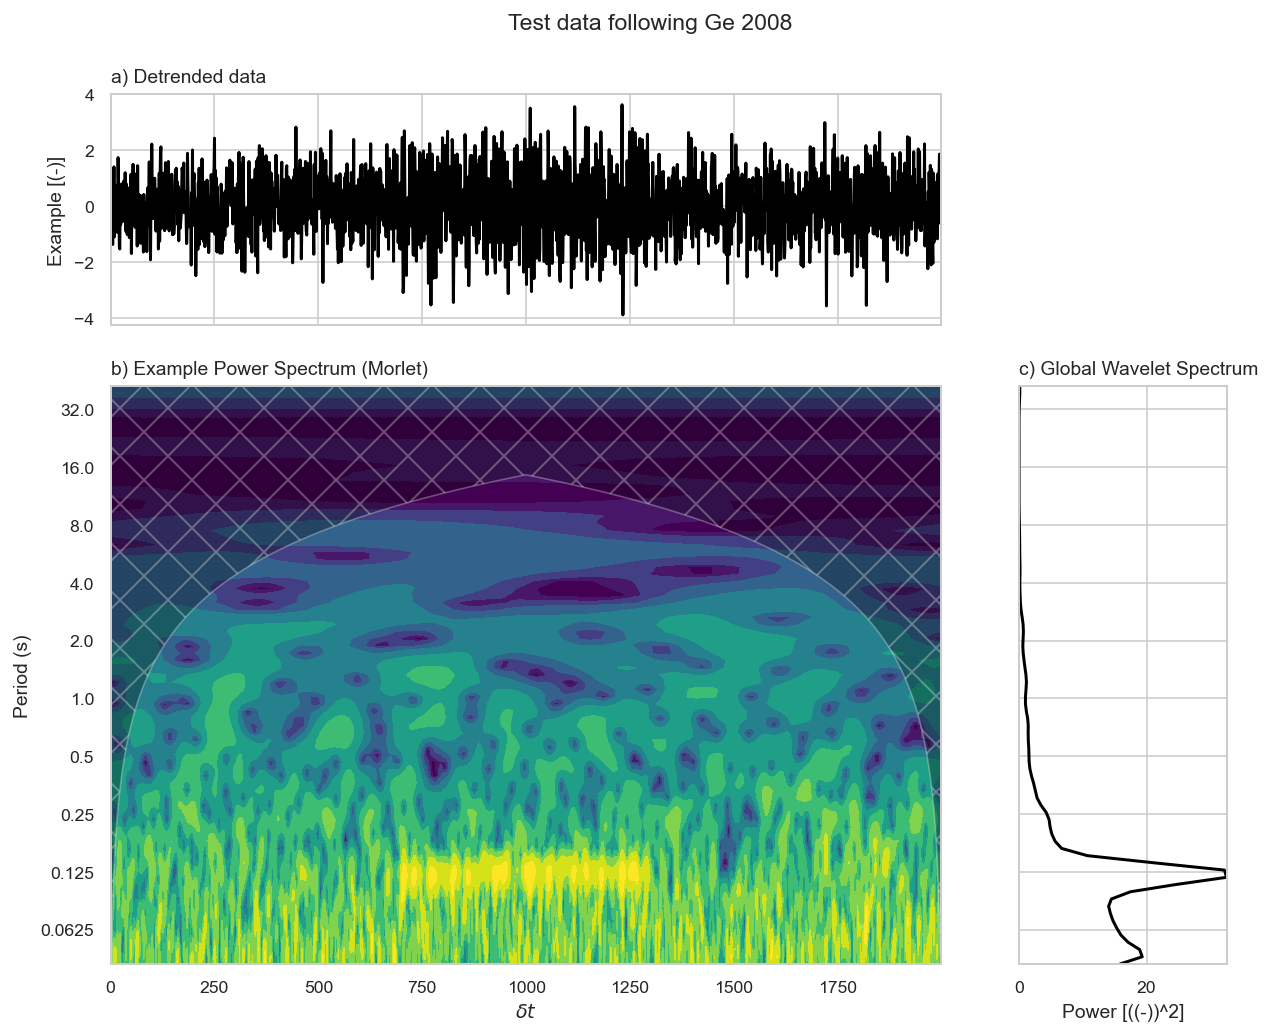

In [36]:
mother = wavelet.Morlet()
octaves = [1 / 8, 10 / (1 / 8)]  

(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
                                                    y, sampling_p, t, mother, scales_to_avg=None,
                                                    octaves=octaves,
                                                    glbl_power_var_scaling=False,
                                                    norm_kwargs={'standardize': False, 'detrend': False})

title = 'Test data following Ge 2008'
label = 'Example'
units = '(-)'
scale_units = 's'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': '$\delta t$'
}

cwt_plt.plot_wv_power(signal_norm=signal_norm,
              x=t,
              dx=sampling_p,
              period=period,
              power=power,
              coi=coi,
              glbl_power=glbl_power,
              scale_avg=scale_avg,
              fig_kwargs=None,
              fig_labels=fig_labels,
              include_colorbar=False)

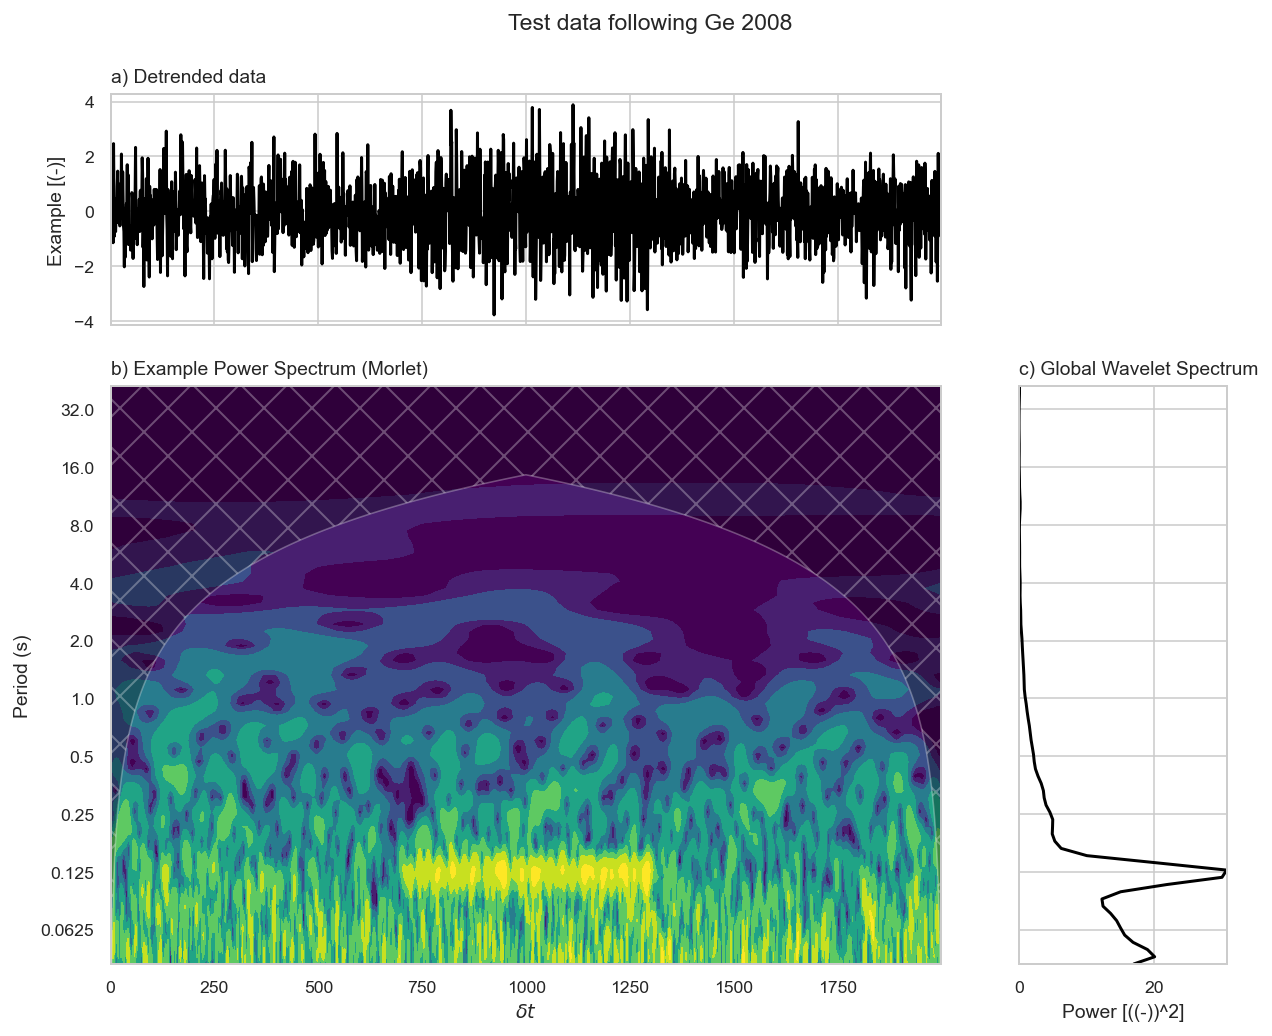

In [37]:
mother = wavelet.Morlet()
octaves = [1 / 8, 10 / (1 / 8)]  

(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
                                                    x, sampling_p, t, mother, scales_to_avg=None,
                                                    octaves=octaves,
                                                    glbl_power_var_scaling=False,
                                                    norm_kwargs={'standardize': False, 'detrend': False})

title = 'Test data following Ge 2008'
label = 'Example'
units = '(-)'
scale_units = 's'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': '$\delta t$'
}

cwt_plt.plot_wv_power(signal_norm=signal_norm,
              x=t,
              dx=sampling_p,
              period=period,
              power=power,
              coi=coi,
              glbl_power=glbl_power,
              scale_avg=scale_avg,
              fig_kwargs=None,
              fig_labels=fig_labels,
              include_colorbar=False)

In [38]:
np.shape(coi)

(2000,)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


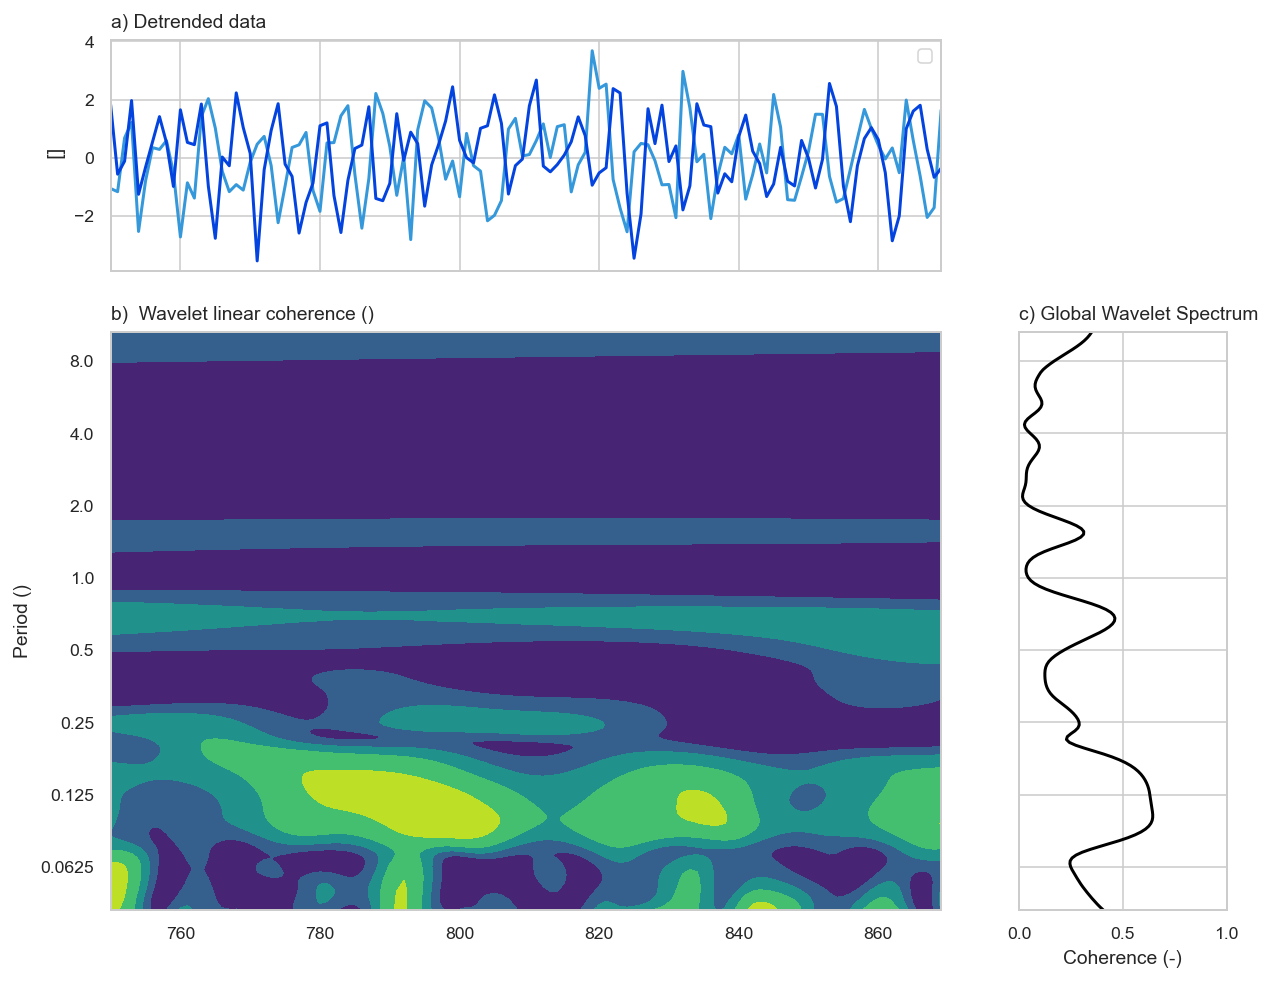

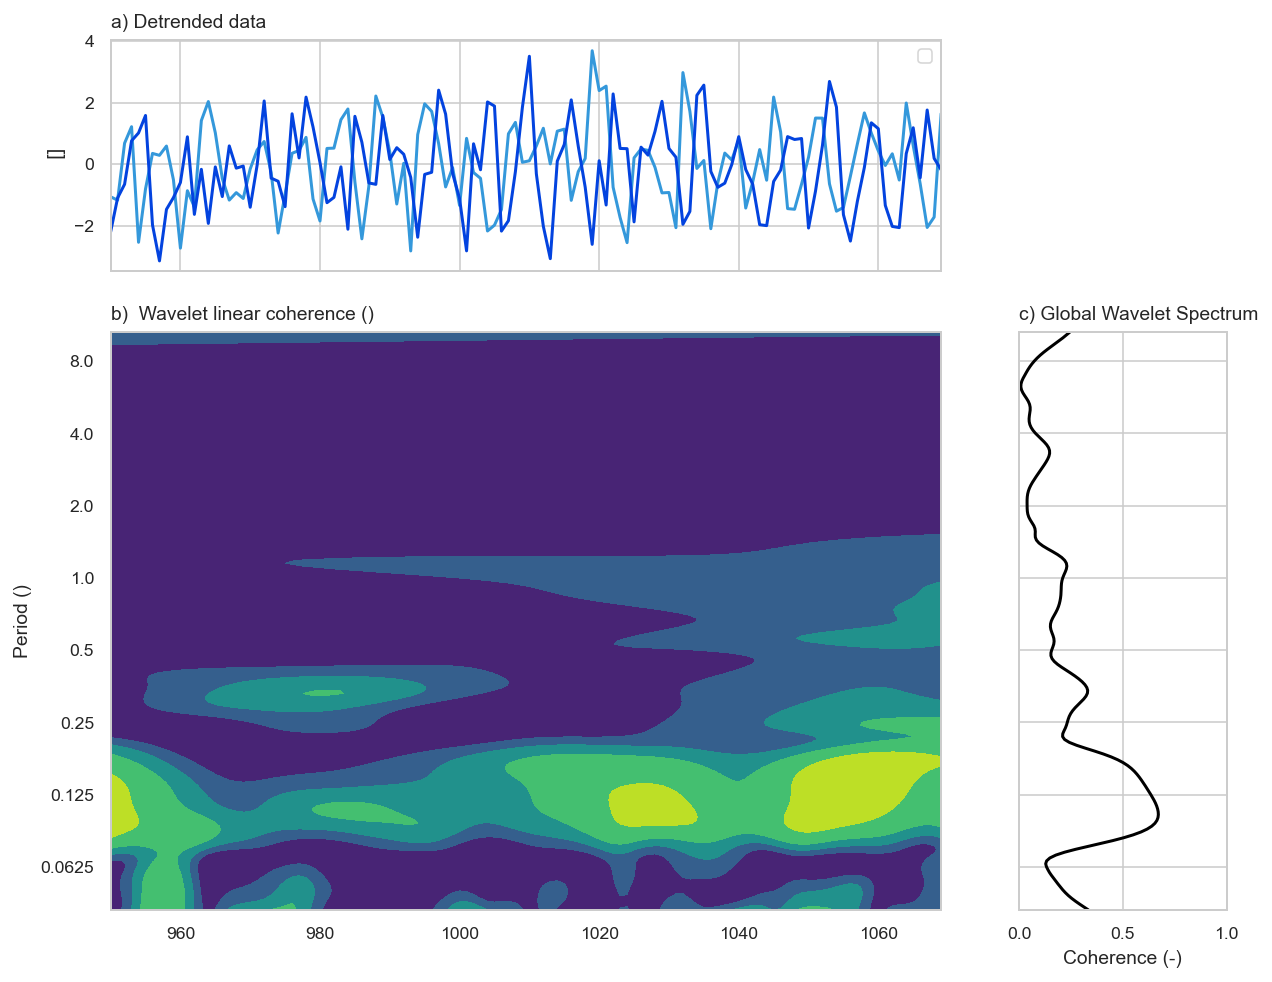

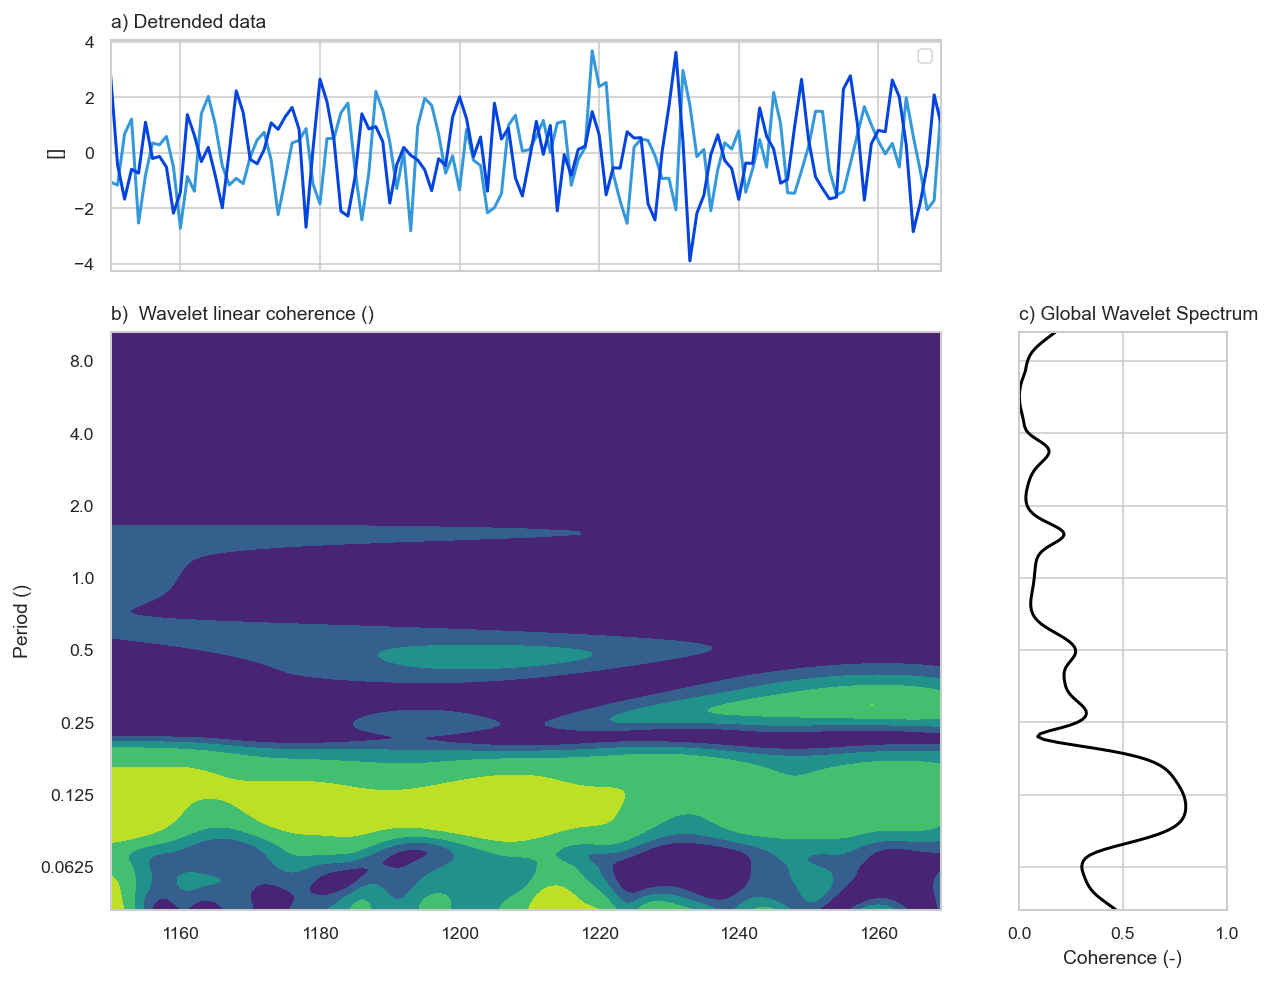

In [39]:
octaves = [1 / 25, 8 / (1 / 25)]  
(WCT, aWCT, W12, periods, coi, angle, s1, s2) = cwt_stat.wavelet_coherent(x, y, sampling_p, octaves[0], 2 * sampling_p, octaves[1], mother)

fig_labels = {
    'title': 'Replication of Ge 2008 test case, section {}',
    'label': 'Synthetic Data',
    'units': '-',
    'scale_units': 's',
    'mother': mother.name,
    'avg_scales': 'None',
    'xlabel': '$\delta t$'
}

n1 = slice(700 + 50, 700 + 50 + 120)
n2 = slice(700 + 250, 700 + 250 + 120)
n3 = slice(700 + 450, 700 + 450 + 120)

n = n1
cwt_plt.plot_wv_power(
    signal_norm=[x[n1], y[n]],
    x=t[n],
    dx=sampling_p,
    period=periods,
    power=WCT[:, n],
    coi=coi[n],
    levels=np.arange(0, 1.1, 0.2),
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels['title'].format('n1'),
    include_colorbar=False,
    coherence=True
)

n = n2
cwt_plt.plot_wv_power(
    signal_norm=[x[n1], y[n]],
    x=t[n],
    dx=sampling_p,
    period=periods,
    power=WCT[:, n],
    coi=coi[n],
    levels=np.arange(0, 1.1, 0.2),
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels['title'].format('n1'),
    include_colorbar=False,
    coherence=True
)

n = n3
cwt_plt.plot_wv_power(
    signal_norm=[x[n1], y[n]],
    x=t[n],
    dx=sampling_p,
    period=periods,
    power=WCT[:, n],
    coi=coi[n],
    levels=np.arange(0, 1.1, 0.2),
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels['title'].format('n1'),
    include_colorbar=False,
    coherence=True
)

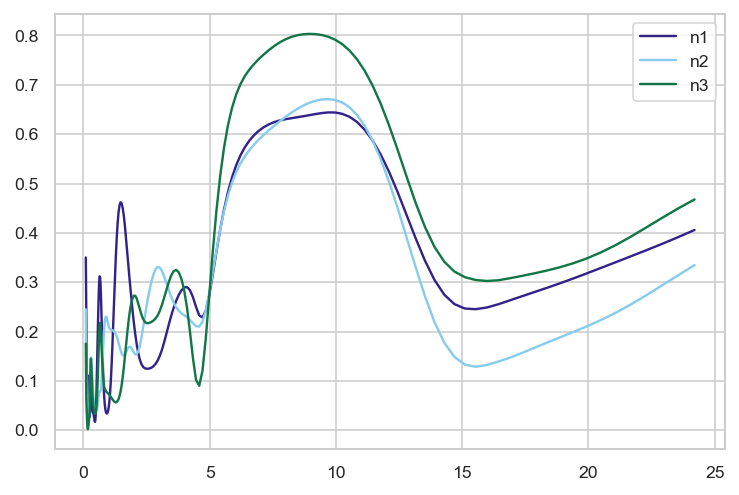

In [51]:
n = n1
plt.plot(1 / periods, WCT[:, n].mean(axis=1), label='n1')
n = n2
plt.plot(1 / periods, WCT[:, n].mean(axis=1), label='n2')
n = n3
plt.plot(1 / periods, WCT[:, n].mean(axis=1), label='n3')
plt.gca().legend()

In [ ]:
plt.figure()
cwt_plt.plot_wv_power(
    signal_norm=[x, y],
    x=t,
    dx=sampling_p,
    period=periods,
    power=np.abs(W12) ** 2,
    coi=coi,
    log_power=True,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False,
    coherence=False
)

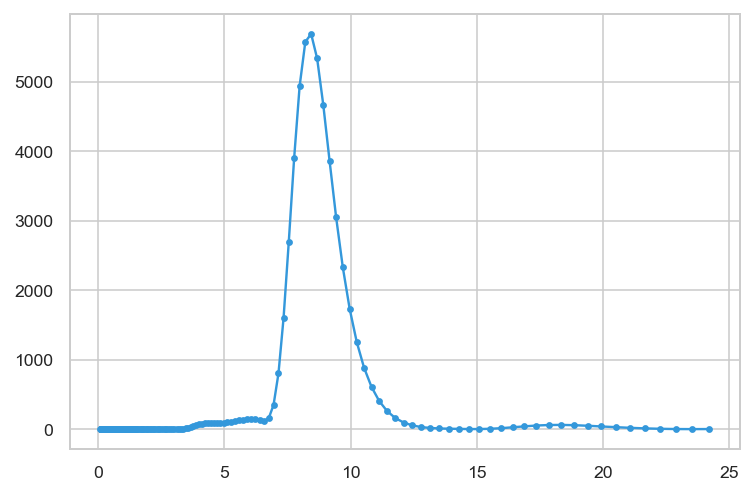

In [9]:
plt.plot(1/periods, np.abs(W12[:, 750]) ** 2, marker='.')

In [10]:
var_x = np.std(x[700:1300]) ** 2
var_y = np.std(y[700:1300]) ** 2

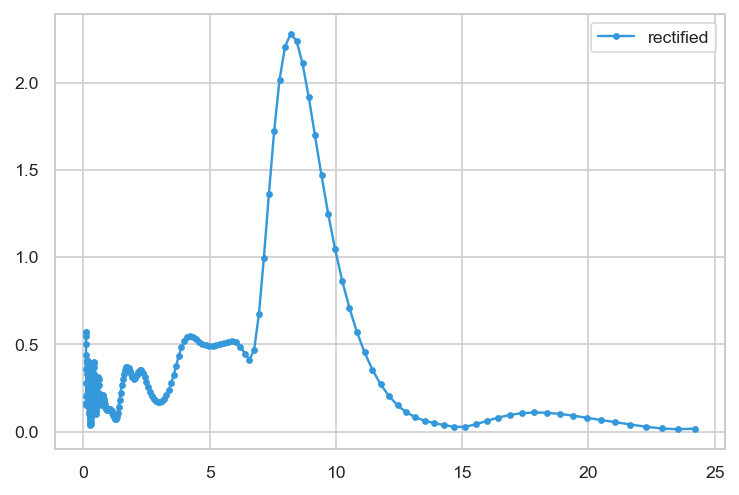

In [11]:
# plt.plot(1/periods, np.abs(W12[:, 750]) * periods, marker='.', label='unrectified')
# plt.plot(1/periods, np.abs(W12[:, 750]), marker='.', label='rectified')
plt.plot(1/periods, np.abs(W12[:, 750]) * periods / (var_x * var_y), marker='.', label='rectified')
plt.gca().legend()

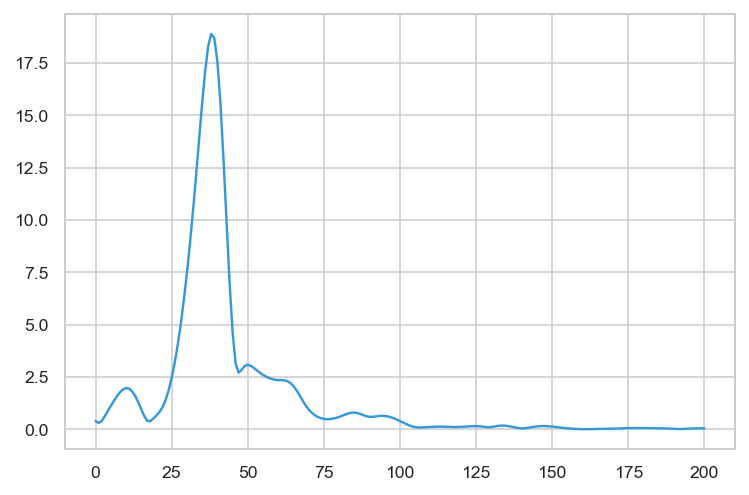

In [12]:
plt.plot(np.abs(W12[:, 750]) / (var_x * var_y))

There is a problem emerging here: part of my problem with getting the XWT to agree with the artificial examples in literature is that the CWT function returns an _already rectified_ spectrum. A separate correction, following Veleda, needs to be applied. In the artificial examples and case studies, I was applying it twice. In cases where the underlying data have different scales (which I am honestly not sure how that could happen, but...) then we would have incorrect values.